# Branch Classifier

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cProfile
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pstats
import scipy.ndimage
from scipy.ndimage import gaussian_filter, median_filter, binary_opening, binary_closing
from scipy.ndimage import binary_dilation, generate_binary_structure, map_coordinates
import sys
import tifffile as tf
import torch
from torch.utils.data import DataLoader

sys.path.append("../")
from data_prep import collect, load, draw, save, image
from data_prep.image import Image
from solvers import branch_classifier
import models
date = datetime.now().strftime("%m-%d-%y")
dtype = torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Collect branch classifier training data
Training data consists of volumetric image patches chosen randomly from the neuron node coordinates given\
in the SWC file with an added small random translation. Image patches are labeled 1 if they are centered on\
 a branch point and 0 otherwise.

### Get sample points from swc files then save sample spherical patches

In [53]:
# Load SWC file data into python lists
swc_dir = os.path.expanduser("~/data/gold166_swc_scaled")
swc_files = os.listdir(swc_dir)

img_dir = os.path.expanduser("~/data/gold166_tifs_scaled/")
img_files = os.listdir(img_dir)

out_dir = os.path.expanduser("~/data/gold166_classifier_data/")
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
    print(f"Created directory: {out_dir}")
if not os.path.exists(os.path.join(out_dir, "observations")):
    os.makedirs(os.path.join(out_dir, "observations"))

In [8]:
stats = pstats.Stats(pr)
stats.sort_stats('cumulative').print_stats()
stats.print_stats()

         3267202 function calls (3180980 primitive calls) in 212.060 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.690    0.690  212.060  212.060 /home/bgray/neurotrack/notebooks/../data_prep/collect.py:152(spherical_patch_dataset)
        1    4.293    4.293  167.503  167.503 /home/bgray/neurotrack/notebooks/../data_prep/collect.py:109(save_spherical_patches)
    10800    9.756    0.001  101.810    0.009 /home/bgray/neurotrack/notebooks/../data_prep/image.py:71(extract_spherical_patch)
    10800    0.160    0.000   84.903    0.008 /home/bgray/anaconda3/envs/neurotrack/lib/python3.8/site-packages/scipy/ndimage/_interpolation.py:358(map_coordinates)
    10800   83.974    0.008   83.974    0.008 {built-in method scipy.ndimage._nd_image.geometric_transform}
      100    0.003    0.000   59.254    0.593 /home/bgray/anaconda3/envs/neurotrack/lib/python3.8/site-packages/torch/serialization.py:333(save)
      10

In [57]:
swc_files[104]

'case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc'

In [64]:
swc_file = '/home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc'
img_file = '/home/brysongray/data/gold166_tifs/case1-slide2-section1-left-cell1_merge_c2.tif'

swc_list = load.swc(swc_file)
img = tf.imread(img_file)

shape = img.shape
del img

sections, sections_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)

segments = []
for section in sections.values():
    segments.append(section)
segments = np.concatenate(segments)

density = draw.draw_neuron_density(segments, shape)

loading file: /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc


/home/brysongray/neurotrack/notebooks/../data_prep/image.py:202: UserWarning: Center tensor([ 78.0350, 603.8480, 556.5220], dtype=torch.float64) is out of bounds for image shape torch.Size([76, 1024, 1024]). Translating to the nearest valid index.
  # get amount of padding for each face
/home/brysongray/neurotrack/notebooks/../data_prep/image.py:202: UserWarning: Center tensor([ 78.0350, 598.4050, 528.3160], dtype=torch.float64) is out of bounds for image shape torch.Size([76, 1024, 1024]). Translating to the nearest valid index.
  # get amount of padding for each face
/home/brysongray/neurotrack/notebooks/../data_prep/image.py:202: UserWarning: Center tensor([ 78.0350, 594.4450, 517.9240], dtype=torch.float64) is out of bounds for image shape torch.Size([76, 1024, 1024]). Translating to the nearest valid index.
  # get amount of padding for each face
/home/brysongray/neurotrack/notebooks/../data_prep/image.py:202: UserWarning: Center tensor([ 78.0350, 593.9520, 517.9240], dtype=torch.

In [63]:
swc_dir = os.path.expanduser("~/data/gold166")
swc_files = os.listdir(swc_dir)

img_dir = os.path.expanduser("~/data/gold166_tifs_scaled/")
img_files = os.listdir(img_dir)

i = 104
swc_list = load.swc(os.path.join(swc_dir, swc_files[i]), verbose=False)
img_name = [img_file for img_file in img_files if img_file.split('.tif')[0] in swc_files[i]]
img_name = img_name[0]

img_path = os.path.join(img_dir, img_name)
img = tf.imread(img_path)
shape = img.shape
del img

sections, sections_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)

segments = []
for section in sections.values():
    segments.append(section)
segments = np.concatenate(segments)

density = draw.draw_neuron_density(segments, shape)

IndexError: list index out of range

In [54]:
collect.save_coordinates_and_annotations(swc_dir, img_dir, out_dir, samples_per_neuron=100, seed=0)

 76%|███████▌  | 104/137 [14:27<04:35,  8.34s/it] 


RuntimeError: The size of tensor a (3) must match the size of tensor b (0) at non-singleton dimension 0

In [4]:
with cProfile.Profile() as pr:
    collect.spherical_patch_dataset(img_dir=img_dir, swc_dir=swc_dir, out_dir=out_dir, samples_per_neuron=100, sync=False)
    stats = pstats.Stats(pr)
    stats.sort_stats('cumulative').print_stats()
    stats.print_stats()

  0%|          | 0/1 [00:00<?, ?it/s]/home/bgray/anaconda3/envs/neurotrack/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  return bound(*args, **kwds)
  0%|          | 0/1 [00:54<?, ?it/s]


NameError: name 'resolution' is not defined

In [18]:
observations = os.listdir(os.path.join(out_dir, "observations"))
obs = observations[0]
img = torch.load(os.path.join(out_dir,"observations", obs))


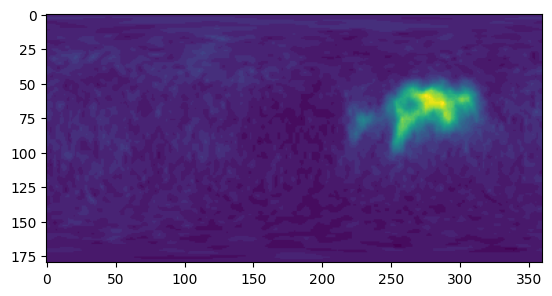

In [46]:
plt.imshow(img[36])

In [40]:
# swc_file = swc_files[1]
# swc_list = load.swc(os.path.join(swc_dir, swc_file), verbose=False)
swc_list = load.swc(os.path.join(swc_dir, 'GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111108_4_E3-left_optic_lobe.v3draw.extract_1.v3dpbd.swc'), verbose=False)

sections, section_graph = parse_swc(swc_list)

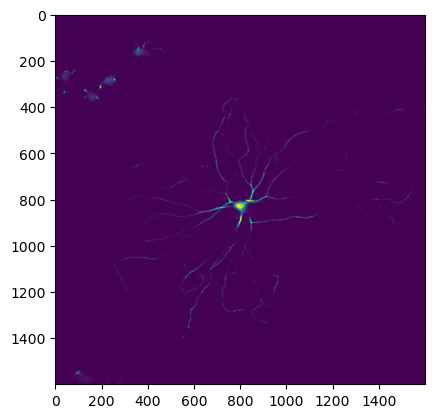

In [18]:
# display the image with a branch point
plt.imshow(img[56])

plt.show()

In [ ]:
'GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111108_4_E3-left_optic_lobe.v3draw.extract_1.v3dpbd.swc'

In [ ]:
samples_per_neuron = 1000
rng = np.random.default_rng(0)

annotations = {}
obs_id = 0
for swc_file in swc_files:
    swc_list = load.swc(os.path.join(swc_dir, swc_file), verbose=False)
    img_name = [img_file for img_file in image_files if img_file.split('.tif')[0] in swc_file]
    try:
        img_name = img_name[0]
    except IndexError:
        continue
    img_path = os.path.join(image_dir, img_name)
    img = tf.imread(img_path)
    shape = img.shape

    del img

    sections, sections_graph = load.parse_swc(swc_list)
    branches, terminals = load.get_critical_points(swc_list, sections)
    segments = []
    for section in sections.values():
        segments.append(section)
    segments = torch.concatenate(segments)


    density = draw.draw_neuron_density(segments, shape)
    mask = draw.draw_neuron_mask(density, threshold=5.0)
    del density

    branch_coords, non_branch_coords = collect.random_points_from_mask(mask, branches, samples_per_neuron, rng=rng)
    
    annotations, obs_id = collect.save_spherical_patches(img_path, branch_coords, non_branch_coords, out_dir, start_id=obs_id, annotations=annotations)

# save annotations
# split into test and training data
name = "gold166"
data_permutation = torch.randperm(len(annotations))
test_idxs = data_permutation[:len(data_permutation)//5].tolist()
training_idxs = data_permutation[len(data_permutation)//5:].tolist()
training_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in training_idxs}
test_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in test_idxs}
# save 
df = pd.DataFrame.from_dict(training_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_training_labels.csv"))
df = pd.DataFrame.from_dict(test_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_test_labels.csv"))

KeyError: 44

### View some example input images

In [14]:
observations = os.listdir(os.path.join(out_dir, "observations"))
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_labels.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img = torch.load(os.path.join(out_dir,"observations", sample.iloc[i,0]), weights_only=True)
    shell = 5 # type: ignore
    ax[i].imshow(img[shell])#, vmin=0, vmax=.0)
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

IndexError: list index out of range

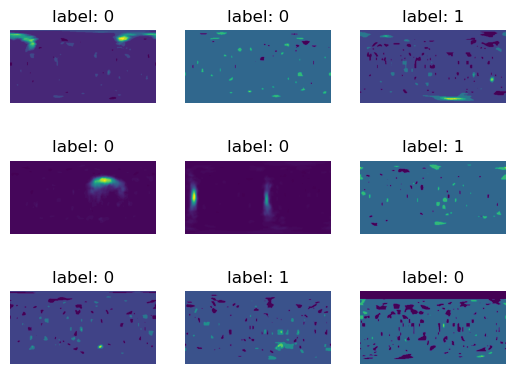

In [6]:
observations = os.listdir(os.path.join(out_dir, "observations"))
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_labels.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img = torch.load(os.path.join(out_dir,"observations", sample.iloc[i,0]), weights_only=True)
    shell = 5 # type: ignore
    ax[i].imshow(img[shell])
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

## Train branch classifier

### Instantiate dataloader for training and test datasets
Dataloaders use a weighted random sampler to balance classes. Additionally, the training dataset\
 adds a random permutation and flip to the image patch at retrieval.

In [4]:
# set source data files paths
name = "gold166"
date = "03-07-25"

training_labels_file = os.path.join(out_dir, f"branch_classifier_{name}_{date}_training_labels.csv")
test_labels_file = os.path.join(out_dir, f"branch_classifier_{name}_{date}_test_labels.csv")
img_dir = os.path.join(out_dir, "observations")

# instantiate training and test datasets
transform = branch_classifier.transform_spherical_patch # random permutation and flip
training_data = branch_classifier.StateData(labels_file=training_labels_file,
                          img_dir=img_dir,
                          transform=transform)
test_data = branch_classifier.StateData(labels_file=test_labels_file,
                          img_dir=img_dir)

# instantiate dataloaders
batchsize=64
training_dataloader = DataLoader(training_data, batch_size=batchsize)
test_dataloader = DataLoader(test_data, batch_size=batchsize)

In [6]:
out_dir = "classifier_weights/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

lr = 1e-3
epochs = 100
classifier = models.ResNet2D(models.ResidualBlock2D, [3, 4, 6, 3], in_channels=18, num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)

branch_classifier.train(training_dataloader, test_dataloader, out_dir, lr, epochs, classifier, state_dict=None)

Epoch 1
-------------------------------
Accuracy: 39.0625, Loss: 0.703391  [   64/  800]
Accuracy: 62.5, Loss: 0.669111  [  704/  800]
Test Error: 
 Accuracy: 56.0%, Avg loss: 4.881491 
           Precision: 0.494, Recall: 0.437
Epoch 2
-------------------------------
Accuracy: 53.125, Loss: 0.704802  [   64/  800]
Accuracy: 70.3125, Loss: 0.652787  [  704/  800]
Test Error: 
 Accuracy: 61.5%, Avg loss: 0.599980 
           Precision: 0.534, Recall: 0.897
Epoch 3
-------------------------------
Accuracy: 68.75, Loss: 0.640434  [   64/  800]
Accuracy: 71.875, Loss: 0.638740  [  704/  800]
Test Error: 
 Accuracy: 56.0%, Avg loss: 0.652177 
           Precision: 0.497, Recall: 0.966
Epoch 4
-------------------------------
Accuracy: 56.25, Loss: 0.658557  [   64/  800]
Accuracy: 71.875, Loss: 0.626720  [  704/  800]
Test Error: 
 Accuracy: 61.0%, Avg loss: 0.633813 
           Precision: 0.529, Recall: 0.943
Epoch 5
-------------------------------
Accuracy: 60.9375, Loss: 0.640943  [   64/

KeyboardInterrupt: 

### Save sample patches and labels from image files

In [ ]:
# save sample patches from the images centered at the sample points
# image_dir = "/home/brysongray/data/simulated_neurons/neuromorpho_sub1_with_artifacts"
image_dir = "/home/brysongray/"
out_dir = "classifier_data"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
name = "neuromorpho_test"

collect.collect_data(sample_points, image_dir, out_dir, name, date)

### View some example input images

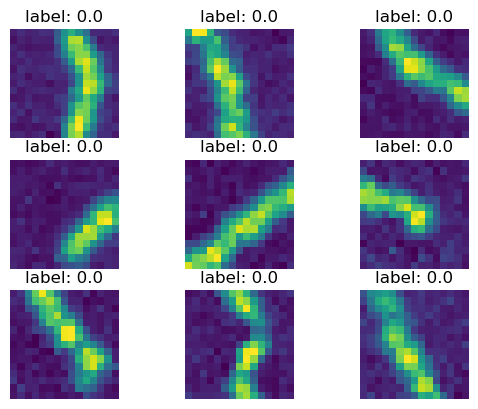

In [10]:
observations = os.listdir(os.path.join(out_dir, "observations"))
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_labels.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img = torch.load(os.path.join(out_dir,"observations", sample.iloc[i,0]), weights_only=True) # type: ignore
    ax[i].imshow(img[0].amax(0))
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

## Train branch classifier

### Instantiate dataloader for training and test datasets
Dataloaders use a weighted random sampler to balance classes. Additionally, the training dataset\
 adds a random permutation and flip to the image patch at retrieval.

In [ ]:
# set source data files paths
training_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_test_labels.csv"
test_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_training_labels.csv"
img_dir = "classifier_data/observations"

# instantiate training and test datasets
transform = branch_classifier.transform # random permutation and flip
training_data = branch_classifier.StateData(labels_file=training_labels_file,
                          img_dir=img_dir,
                          transform=transform)
test_data = branch_classifier.StateData(labels_file=test_labels_file,
                          img_dir=img_dir)

# instantiate dataloaders
training_dataloader = branch_classifier.init_dataloader(training_data)
test_dataloader = branch_classifier.init_dataloader(test_data)

## View balanced data

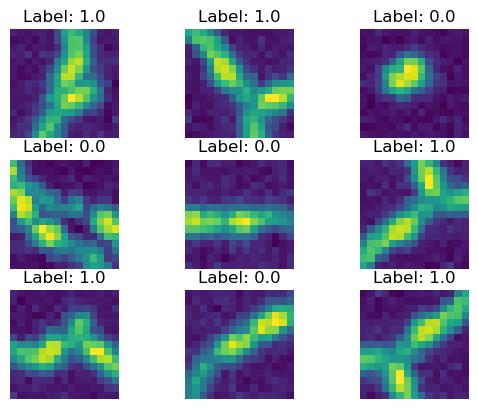

In [14]:
fig, axs = plt.subplots(3,3)
axs = axs.flatten()

X,y = next(iter(training_dataloader))
for i, ax in enumerate(axs):
    ax.imshow(X[i,0].amax(0))
    ax.set_title(f"Label: {y[i]}")
    ax.set_axis_off()

In [17]:
out_dir = "classifier_weights/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

lr = 1e-3
epochs = 5
classifier = models.ResNet(models.ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)

branch_classifier.train(training_dataloader, test_dataloader, out_dir, lr, epochs, classifier, state_dict=None)


Epoch 1
-------------------------------
Accuracy: 40.0, Loss: 0.405724  [   30/   30]
Test Error: 
 Accuracy: 50.0%, Avg loss: 24.919770 
           Precision: 0.500, Recall: 1.000
Epoch 2
-------------------------------
Accuracy: 76.66666666666667, Loss: 0.828855  [   30/   30]
Test Error: 
 Accuracy: 53.3%, Avg loss: 22.108765 
           Precision: 0.533, Recall: 1.000
Epoch 3
-------------------------------
Accuracy: 80.0, Loss: 0.543504  [   30/   30]
Test Error: 
 Accuracy: 51.7%, Avg loss: 23.350894 
           Precision: 0.517, Recall: 1.000
Epoch 4
-------------------------------
Accuracy: 70.0, Loss: 0.260397  [   30/   30]
Test Error: 
 Accuracy: 42.5%, Avg loss: 32.415985 
           Precision: 0.425, Recall: 1.000
Epoch 5
-------------------------------
Accuracy: 93.33333333333333, Loss: 0.181836  [   30/   30]
Test Error: 
 Accuracy: 48.3%, Avg loss: 26.552392 
           Precision: 0.483, Recall: 1.000
Done!
